# Задание по оптимизации модели на основе анализа ошибок и отбора признаков  
---  
> урок_№: 2    
домашняя_работа_№: 2  
исполнитель: Маъруф Ибрагимов  

In [1]:
import funcs as fn
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

## 1. Анализ ошибок

**Анализ производительности модели**:
   - Проанализируйте работу модели, созданной в ДЗ1, по отдельным категориям признаков. Вычислите **AUC** для каждой категории и определите, есть ли категории, где модель показывает слабую производительность.
   - Визуализируйте результаты анализа.

### Строим модель

In [2]:
df=fn.get_bank_data()

In [3]:
df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
cat_features=['country', 'gender', 'products_number', 'credit_card', 'active_member', 'tenure']

In [5]:
model, X_train, y_train, X_test, y_test, model_metrics = fn.build_model(df, cat_features, 'classifier')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

auc_train: 0.7367, auc_test: 0.7346


### Проверяем на data_leakage

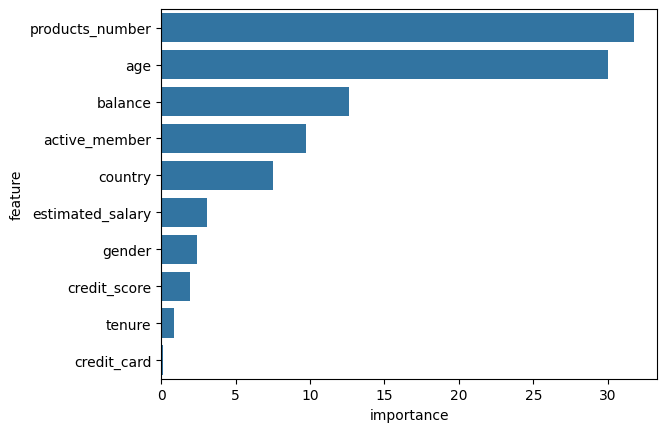

In [6]:
feature_importance=fn.get_feature_importance(model, X_train.columns)
fn.plot_feature_importance(feature_importance)

> Явно выделяющихся признаков, которые бы могли свидетельствовать об утечке данных, не наблюдается.


### Анализируем ошибки

In [7]:
aucs_per_feature=fn.get_auc_per_category(model, X_train, y_train, X_test, y_test, cat_features)

In [8]:
fn.print_in_sequence(aucs_per_feature, 'feature', '\nAUC and Counts for **{}** sorted by AUC difference:\n')


AUC and Counts for **country** sorted by AUC difference:


,Category,Train Count,Test Count,Train AUC,Test AUC,feature
0,Germany,2011,498,0.767244,0.754592,country
1,France,3994,1020,0.711911,0.702839,country
2,Spain,1995,482,0.698945,0.712531,country



--------------------------------------------------




AUC and Counts for **gender** sorted by AUC difference:


,Category,Train Count,Test Count,Train AUC,Test AUC,feature
3,Female,3638,905,0.747754,0.726974,gender
4,Male,4362,1095,0.719216,0.739151,gender



--------------------------------------------------




AUC and Counts for **products_number** sorted by AUC difference:


,Category,Train Count,Test Count,Train AUC,Test AUC,feature
5,3,213,53,0.606613,0.571429,products_number
6,2,3690,900,0.591373,0.569225,products_number
7,1,4052,1032,0.714358,0.720124,products_number
8,4,45,15,NaN,NaN,products_number



--------------------------------------------------




AUC and Counts for **credit_card** sorted by AUC difference:


,Category,Train Count,Test Count,Train AUC,Test AUC,feature
9,0,2372,573,0.738879,0.731400,credit_card
10,1,5628,1427,0.735741,0.736015,credit_card



--------------------------------------------------




AUC and Counts for **active_member** sorted by AUC difference:


,Category,Train Count,Test Count,Train AUC,Test AUC,feature
11,1,4102,1049,0.662082,0.658586,active_member
12,0,3898,951,0.771767,0.773023,active_member



--------------------------------------------------




AUC and Counts for **tenure** sorted by AUC difference:


,Category,Train Count,Test Count,Train AUC,Test AUC,feature
13,10,393,97,0.785585,0.684885,tenure
14,4,803,186,0.727328,0.677789,tenure
15,5,829,183,0.766709,0.718554,tenure
16,9,768,216,0.748147,0.709617,tenure
17,1,815,220,0.770842,0.766051,tenure
18,8,805,220,0.728238,0.724719,tenure
19,6,777,190,0.689475,0.703947,tenure
20,3,801,208,0.724318,0.748472,tenure
21,7,832,196,0.723892,0.784117,tenure
22,0,333,80,0.707213,0.769231,tenure



--------------------------------------------------



>* Анализ предиктора `products_number` вернул пустые значения по категории 4, что говорит о явном недостатке наблюдений по этой категории.
>* Анализ предиктора `tenure` показывает значимые снижения тестовых метрик по категориям 10, 4, 5 и 9 

#### Ищем и устраняем ошибки по предиктору `products_number`

In [9]:
df_2=df.copy()

In [10]:
fn.compare_proportions('products_number', X_train, X_test)

,train,test
products_number,,
1,0.51,0.52
2,0.46,0.45
3,0.03,0.03
4,0.01,0.01


In [11]:
df_2['products_number']=np.where(df_2['products_number']>2, '>2', df_2['products_number'])

In [12]:
df_2['products_number'].value_counts(normalize=True)

products_number
1     0.5084
2     0.4590
>2    0.0326
Name: proportion, dtype: float64

In [13]:
model_2, X_train_2, y_train_2, X_test_2, y_test_2, model_metrics_2 = fn.build_model(df_2, cat_features, 'classifier')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

auc_train: 0.7376, auc_test: 0.7346


In [14]:
fn.get_auc_per_category(model, X_train, y_train, X_test, y_test, 'products_number')

,Category,Train Count,Test Count,Train AUC,Test AUC,feature
0,3,213,53,0.606613,0.571429,products_number
1,2,3690,900,0.591373,0.569225,products_number
2,1,4052,1032,0.714358,0.720124,products_number
3,4,45,15,NaN,NaN,products_number


#### Ищем и устраняем ошибки по предиктору `tenure`

In [15]:
fn.compare_proportions('tenure', X_train, X_test).sort_index()

,train,test
tenure,,
0,0.04,0.04
1,0.10,0.11
2,0.11,0.10
3,0.10,0.10
4,0.10,0.09
5,0.10,0.09
6,0.10,0.10
7,0.10,0.10
8,0.10,0.11


> За исключением категорий 0 и 10, по всем остальным категориям пропорции распределены более менее равномерно как в тренировочном, так и в тестовом сете.  
> Но малая пропорция категории 10 скорее всего не является причиной ошибки, поскольку категория 0 даже при более низкой пропорции показывает рост метрики на тестовом сете.  

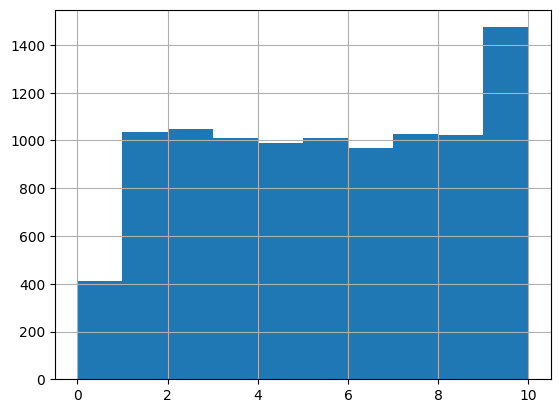

In [16]:
df_2['tenure'].hist();

In [17]:
tenures_list=[4, 5, 9, 10]

erroneous_tenures=pd.concat([
    X_train_2.query("tenure.isin(@tenures_list)").assign(set='train'),
    X_test_2.query("tenure.isin(@tenures_list)").assign(set='test')
], ignore_index=True)

##### Сравниваем по числовым предикторам

In [18]:
cont_features=['credit_score', 'age', 'balance', 'estimated_salary']

In [19]:
def get_description(data, stats=['mean', 'std', '50%']):
    """
    Трансформирует описание датафрейма.

    Принимает:
        * data - датафрейм с данными
        * stats - список стат. параметров

    Возвращает:
        * df - датафрейм с описанием
    """
    if type(stats)!=list:
        stats=[stats]
    df=data.describe().T[stats]
    return round(df, 2)

In [20]:
(
    erroneous_tenures
    .groupby(['tenure', 'set'])[cont_features].apply(lambda x: get_description(x))
    .unstack(level=1)
)

mean                  std                  50%  \
set                           test      train      test     train       test   
tenure                                                                         
4      credit_score         651.88     651.42    101.19     94.50     648.00   
       age                   39.59      37.93     10.42     10.26      38.00   
       balance            76935.45   73393.21  61787.76  61539.48   96403.25   
       estimated_salary   98639.97  100152.18  56240.73  58224.27  103862.01   
5      credit_score         643.28     652.13     87.64     98.23     640.00   
       age                   39.36      39.27     11.19     10.63      37.00   
       balance            79939.63   75672.69  62623.13  63606.52   98400.61   
       estimated_salary  102913.86  100926.67  53938.63  56331.58  103269.00   
9      credit_score         650.36     654.56    100.39     95.31     667.00   
       age                   39.87      39.20     10.58     10.57      37.00   
       balance            77217.61   76378.31  61479.62  62874.32   98926.30   
       estimated_salary   91497.77  101643.91  60390.79  56748.22   81971.23   
10     credit_score         654.32     653.57     96.93     96.04     651.00   
       age                   39.80      38.99     12.39     10.46      39.00   
       balance            80314.26   72351.13  64154.74  59712.06   95502.21   
       estimated_salary   96668.20  104320.81  58382.33  56765.34   97893.40   

                                    
set                          train  
tenure                              
4      credit_score         652.00  
       age                   37.00  
       balance            92805.72  
       estimated_salary  100998.50  
5      credit_score         656.00  
       age                   38.00  
       balance            94754.00  
       estimated_salary  101192.08  
9      credit_score         653.00  
       age                   38.00  
       balance           100309.02  
       estimated_salary  101010.10  
10     credit_score         655.00  
       age                   38.00  
       balance            91760.11  
       estimated_salary  102517.83

> По категориям 4 и 5 сравнение показало, что наблюдается разница распределений по полю `credit_score` между тренировочным и тестовым сетом.  
> По категории 9 сравнение показало, что наблюдается разница распределений по полю `estimated_salary` между тренировочным и тестовым сетом. 
> По категории 10 сравнение показало, что наблюдается разница распределений по полю `balance` между тренировочным и тестовым сетом.

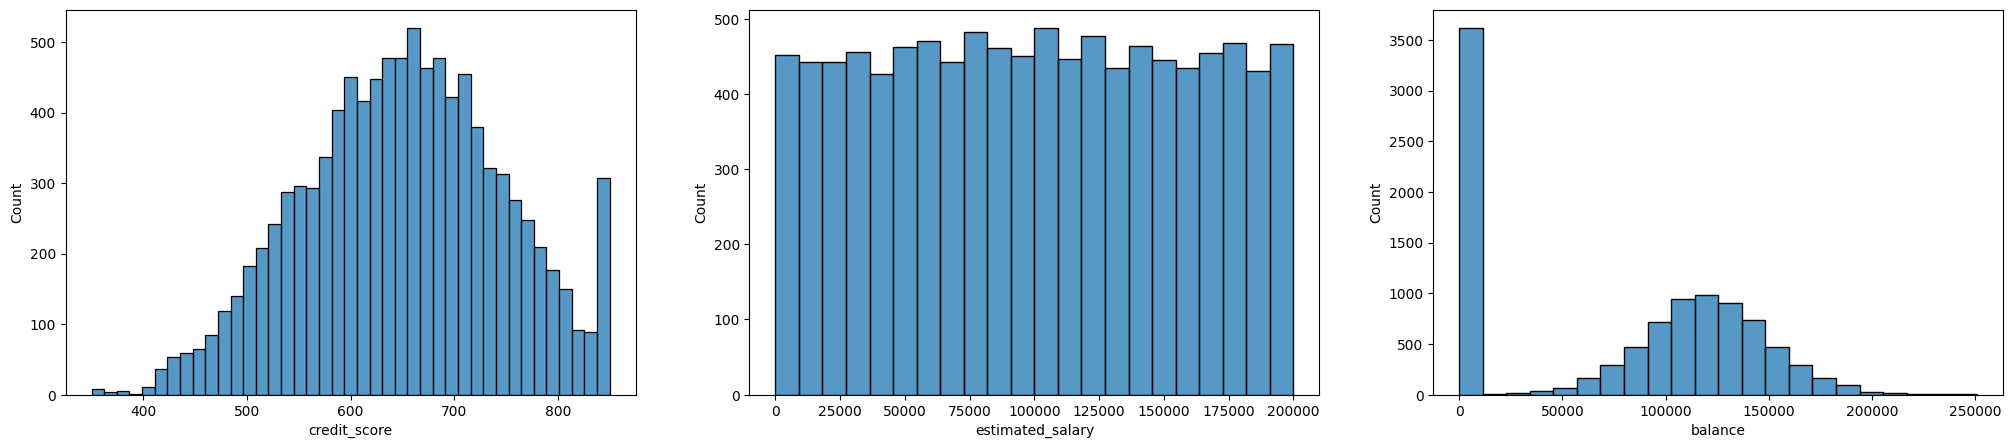

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(25, 5))
 
#fig.suptitle('')
 
sns.histplot(ax=axes[0], data=df_2, x='credit_score')
sns.histplot(ax=axes[1], data=df_2, x='estimated_salary')
sns.histplot(ax=axes[2], data=df_2, x='balance')

plt.show();

In [22]:
df_2['credit_score_bin']=pd.cut(df_2['credit_score'], bins=[-np.inf, 600, 700, +np.inf], labels=['<=600', '<=700', '>700']).astype(object)
df_2['salary_bin']=pd.cut(df_2['estimated_salary'], bins=[-np.inf, 50000, 100000, 150000, +np.inf], labels=['<=50000', '<=100000', '<=150000', '>150000']).astype(object)
df_2['balance_bin']=pd.cut(df_2['balance'], bins=[-np.inf, 90000, 150000, +np.inf], labels=['<=90000', '<=150000', '>150000'])

In [23]:
cat_features_2=cat_features[:-1] + ['credit_score_bin', 'salary_bin', 'balance_bin', 'tenure']

In [24]:
model_2, X_train_2, y_train_2, X_test_2, y_test_2, model_metrics_2 = fn.build_model(df_2, cat_features_2, 'classifier')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

auc_train: 0.7361, auc_test: 0.7254


In [25]:
fn.print_in_sequence(
    fn.get_auc_per_category(model_2, X_train_2, y_train_2, X_test_2, y_test_2, ['tenure', 'credit_score_bin', 'salary_bin', 'balance_bin']), 
    'feature', 
    '\nAUC and Counts for **{}** sorted by AUC difference:\n'
)



AUC and Counts for **tenure** sorted by AUC difference:


,Category,Train Count,Test Count,Train AUC,Test AUC,feature
0,5,829,183,0.770545,0.697278,tenure
1,9,768,216,0.750215,0.691707,tenure
2,10,393,97,0.785585,0.731107,tenure
3,4,803,186,0.719293,0.667585,tenure
4,1,815,220,0.770842,0.742242,tenure
5,8,805,220,0.723474,0.721910,tenure
6,6,777,190,0.698161,0.703947,tenure
7,3,801,208,0.723114,0.745582,tenure
8,0,333,80,0.700642,0.735897,tenure
9,2,844,204,0.736019,0.797178,tenure



--------------------------------------------------




AUC and Counts for **credit_score_bin** sorted by AUC difference:


,Category,Train Count,Test Count,Train AUC,Test AUC,feature
11,<=700,3073,745,0.731947,0.703649,credit_score_bin
12,>700,2526,590,0.734153,0.713034,credit_score_bin
13,<=600,2401,665,0.742584,0.758514,credit_score_bin



--------------------------------------------------




AUC and Counts for **salary_bin** sorted by AUC difference:


,Category,Train Count,Test Count,Train AUC,Test AUC,feature
14,>150000,1981,474,0.762030,0.737066,salary_bin
15,<=150000,2042,513,0.728201,0.710787,salary_bin
16,<=100000,2031,506,0.711716,0.702911,salary_bin
17,<=50000,1946,507,0.742828,0.746028,salary_bin



--------------------------------------------------




AUC and Counts for **balance_bin** sorted by AUC difference:


,Category,Train Count,Test Count,Train AUC,Test AUC,feature
18,>150000,775,194,0.719730,0.681285,balance_bin
19,<=150000,3510,919,0.743359,0.726348,balance_bin
20,<=90000,3715,887,0.724601,0.732891,balance_bin



--------------------------------------------------



> Результат показывает, что по полю `tenure` удалось уменьшить разрыв между тренировочной и тестовой метриками, но незначительно.  
> Также это привело к снижению общей метрики на несколько процентных пунктов.

##### Сравниваем по категориальным предикторам

In [26]:
erroneous_tenures=pd.concat([
    X_train_2.query("tenure.isin(@tenures_list)").assign(set='train'),
    X_test_2.query("tenure.isin(@tenures_list)").assign(set='test')
], ignore_index=True)

In [27]:
cat_proportions=pd.concat(
    list(map(
        lambda x: (
            erroneous_tenures
            .groupby(['set', 'tenure'])[x].value_counts(normalize=True)
            .unstack(level=0)
            .assign(feature=x)
            .reset_index()
            .rename(columns={x:'category'})
        ),
        cat_features_2[:-1]
    )),
    #ignore_index=True
)
cat_proportions.columns.name=None 

In [28]:
for feature in cat_proportions['feature'].unique():
    print(f'# {feature.upper()}')
    fn.print_in_sequence(cat_proportions.query("feature==@feature"), 'tenure', 'proportions comparison for **{} years** tenure')

# COUNTRY


proportions comparison for **4 years** tenure

,tenure,category,test,train,feature
0,4,France,0.489247,0.524284,country
1,4,Germany,0.252688,0.230386,country
2,4,Spain,0.258065,0.245330,country



--------------------------------------------------



proportions comparison for **5 years** tenure

,tenure,category,test,train,feature
3,5,France,0.453552,0.484922,country
4,5,Germany,0.278689,0.250905,country
5,5,Spain,0.267760,0.264174,country



--------------------------------------------------



proportions comparison for **9 years** tenure

,tenure,category,test,train,feature
6,9,France,0.518519,0.510417,country
7,9,Germany,0.296296,0.266927,country
8,9,Spain,0.185185,0.222656,country



--------------------------------------------------



proportions comparison for **10 years** tenure

,tenure,category,test,train,feature
9,10,France,0.515464,0.491094,country
10,10,Germany,0.226804,0.269720,country
11,10,Spain,0.257732,0.239186,country



--------------------------------------------------

# GENDER


proportions comparison for **4 years** tenure

,tenure,category,test,train,feature
0,4,Female,0.451613,0.445828,gender
1,4,Male,0.548387,0.554172,gender



--------------------------------------------------



proportions comparison for **5 years** tenure

,tenure,category,test,train,feature
2,5,Female,0.448087,0.441496,gender
3,5,Male,0.551913,0.558504,gender



--------------------------------------------------



proportions comparison for **9 years** tenure

,tenure,category,test,train,feature
4,9,Female,0.472222,0.416667,gender
5,9,Male,0.527778,0.583333,gender



--------------------------------------------------



proportions comparison for **10 years** tenure

,tenure,category,test,train,feature
6,10,Female,0.453608,0.51145,gender
7,10,Male,0.546392,0.48855,gender



--------------------------------------------------

# PRODUCTS_NUMBER


proportions comparison for **4 years** tenure

,tenure,category,test,train,feature
0,4,1,0.532258,0.504359,products_number
1,4,2,0.430108,0.475716,products_number
2,4,>2,0.037634,0.019925,products_number



--------------------------------------------------



proportions comparison for **5 years** tenure

,tenure,category,test,train,feature
3,5,1,0.546448,0.483715,products_number
4,5,2,0.387978,0.478890,products_number
5,5,>2,0.065574,0.037394,products_number



--------------------------------------------------



proportions comparison for **9 years** tenure

,tenure,category,test,train,feature
6,9,1,0.504630,0.509115,products_number
7,9,2,0.472222,0.454427,products_number
8,9,>2,0.023148,0.036458,products_number



--------------------------------------------------



proportions comparison for **10 years** tenure

,tenure,category,test,train,feature
9,10,1,0.515464,0.486005,products_number
10,10,2,0.443299,0.470738,products_number
11,10,>2,0.041237,0.043257,products_number



--------------------------------------------------

# CREDIT_CARD


proportions comparison for **4 years** tenure

,tenure,category,test,train,feature
0,4,0,0.231183,0.295143,credit_card
1,4,1,0.768817,0.704857,credit_card



--------------------------------------------------



proportions comparison for **5 years** tenure

,tenure,category,test,train,feature
2,5,0,0.306011,0.308806,credit_card
3,5,1,0.693989,0.691194,credit_card



--------------------------------------------------



proportions comparison for **9 years** tenure

,tenure,category,test,train,feature
4,9,0,0.333333,0.286458,credit_card
5,9,1,0.666667,0.713542,credit_card



--------------------------------------------------



proportions comparison for **10 years** tenure

,tenure,category,test,train,feature
6,10,0,0.268041,0.277354,credit_card
7,10,1,0.731959,0.722646,credit_card



--------------------------------------------------

# ACTIVE_MEMBER


proportions comparison for **4 years** tenure

,tenure,category,test,train,feature
0,4,0,0.505376,0.491905,active_member
1,4,1,0.494624,0.508095,active_member



--------------------------------------------------



proportions comparison for **5 years** tenure

,tenure,category,test,train,feature
2,5,0,0.546448,0.489747,active_member
3,5,1,0.453552,0.510253,active_member



--------------------------------------------------



proportions comparison for **9 years** tenure

,tenure,category,test,train,feature
4,9,0,0.518519,0.522135,active_member
5,9,1,0.481481,0.477865,active_member



--------------------------------------------------



proportions comparison for **10 years** tenure

,tenure,category,test,train,feature
6,10,0,0.43299,0.506361,active_member
7,10,1,0.56701,0.493639,active_member



--------------------------------------------------

# CREDIT_SCORE_BIN


proportions comparison for **4 years** tenure

,tenure,category,test,train,feature
0,4,<=600,0.333333,0.310087,credit_score_bin
1,4,<=700,0.360215,0.384807,credit_score_bin
2,4,>700,0.306452,0.305106,credit_score_bin



--------------------------------------------------



proportions comparison for **5 years** tenure

,tenure,category,test,train,feature
3,5,<=600,0.316940,0.295537,credit_score_bin
4,5,<=700,0.415301,0.378770,credit_score_bin
5,5,>700,0.267760,0.325694,credit_score_bin



--------------------------------------------------



proportions comparison for **9 years** tenure

,tenure,category,test,train,feature
6,9,<=600,0.310185,0.292969,credit_score_bin
7,9,<=700,0.356481,0.372396,credit_score_bin
8,9,>700,0.333333,0.334635,credit_score_bin



--------------------------------------------------



proportions comparison for **10 years** tenure

,tenure,category,test,train,feature
9,10,<=600,0.278351,0.300254,credit_score_bin
10,10,<=700,0.391753,0.368957,credit_score_bin
11,10,>700,0.329897,0.330789,credit_score_bin



--------------------------------------------------

# SALARY_BIN


proportions comparison for **4 years** tenure

,tenure,category,test,train,feature
0,4,<=100000,0.247312,0.235367,salary_bin
1,4,<=150000,0.317204,0.264010,salary_bin
2,4,<=50000,0.231183,0.257783,salary_bin
3,4,>150000,0.204301,0.242839,salary_bin



--------------------------------------------------



proportions comparison for **5 years** tenure

,tenure,category,test,train,feature
4,5,<=100000,0.273224,0.258142,salary_bin
5,5,<=150000,0.300546,0.258142,salary_bin
6,5,<=50000,0.196721,0.232811,salary_bin
7,5,>150000,0.229508,0.250905,salary_bin



--------------------------------------------------



proportions comparison for **9 years** tenure

,tenure,category,test,train,feature
8,9,<=100000,0.231481,0.253906,salary_bin
9,9,<=150000,0.250000,0.247396,salary_bin
10,9,<=50000,0.314815,0.238281,salary_bin
11,9,>150000,0.203704,0.260417,salary_bin



--------------------------------------------------



proportions comparison for **10 years** tenure

,tenure,category,test,train,feature
12,10,<=100000,0.226804,0.264631,salary_bin
13,10,<=150000,0.257732,0.254453,salary_bin
14,10,<=50000,0.288660,0.213740,salary_bin
15,10,>150000,0.226804,0.267176,salary_bin



--------------------------------------------------

# BALANCE_BIN


proportions comparison for **4 years** tenure

,tenure,category,test,train,feature
0,4,<=90000,0.456989,0.484433,balance_bin
1,4,<=150000,0.456989,0.437111,balance_bin
2,4,>150000,0.086022,0.078456,balance_bin



--------------------------------------------------



proportions comparison for **5 years** tenure

,tenure,category,test,train,feature
3,5,<=90000,0.426230,0.474065,balance_bin
4,5,<=150000,0.448087,0.417370,balance_bin
5,5,>150000,0.125683,0.108565,balance_bin



--------------------------------------------------



proportions comparison for **9 years** tenure

,tenure,category,test,train,feature
6,9,<=90000,0.444444,0.451823,balance_bin
7,9,<=150000,0.462963,0.454427,balance_bin
8,9,>150000,0.092593,0.093750,balance_bin



--------------------------------------------------



proportions comparison for **10 years** tenure

,tenure,category,test,train,feature
9,10,<=90000,0.453608,0.498728,balance_bin
10,10,<=150000,0.443299,0.437659,balance_bin
11,10,>150000,0.103093,0.063613,balance_bin



--------------------------------------------------



> По категории 5 наблюадется значительное различие в пропорциях категорий по полю `products_number` между тренировочным и тестовым сетом.  
> Но как решить эти проблему я не знаю.

## 2. Инженерия признаков

**Создание новых признаков:**
   - Сгенерируйте **новые** признаки на основе существующих. Затем обучите модель с учетом новых признаков и оцените её производительность.

### Добавляем полиномы

In [29]:
num_features=['credit_score', 'age', 'tenure', 'balance', 'credit_card', 'active_member', 'estimated_salary']

In [30]:
poly_df=fn.add_polynomes(df, num_features)

In [31]:
poly_df.head()

,country,gender,products_number,churn,credit_score,age,tenure,balance,credit_card,active_member,...,credit_card^2 estimated_salary^2,credit_card active_member^3,credit_card active_member^2 estimated_salary,credit_card active_member estimated_salary^2,credit_card estimated_salary^3,active_member^4,active_member^3 estimated_salary,active_member^2 estimated_salary^2,active_member estimated_salary^3,estimated_salary^4
0,France,Female,1,1,619.0,42.0,2.0,0.00,1.0,1.0,...,1.027160e+10,1.0,101348.88,1.027160e+10,1.041015e+15,1.0,101348.88,1.027160e+10,1.041015e+15,1.055057e+20
1,Spain,Female,1,0,608.0,41.0,1.0,83807.86,0.0,1.0,...,0.000000e+00,0.0,0.00,0.000000e+00,0.000000e+00,1.0,112542.58,1.266583e+10,1.425445e+15,1.604233e+20
2,France,Female,3,1,502.0,42.0,8.0,159660.80,1.0,0.0,...,1.298040e+10,0.0,0.00,0.000000e+00,1.478878e+15,0.0,0.00,0.000000e+00,0.000000e+00,1.684909e+20
3,France,Female,2,0,699.0,39.0,1.0,0.00,0.0,0.0,...,0.000000e+00,0.0,0.00,0.000000e+00,0.000000e+00,0.0,0.00,0.000000e+00,0.000000e+00,7.750049e+19
4,Spain,Female,1,0,850.0,43.0,2.0,125510.82,1.0,1.0,...,6.254295e+09,1.0,79084.10,6.254295e+09,4.946153e+14,1.0,79084.10,6.254295e+09,4.946153e+14,3.911620e+19


In [32]:
poly_df[['credit_card', 'active_member', 'tenure', 'products_number']]=poly_df[['credit_card', 'active_member', 'tenure', 'products_number']].astype(int)

In [33]:
poly_model, X_train_poly, y_train_poly, X_test_poly, y_test_poly, model_metrics_poly = fn.build_model(poly_df, cat_features, 'classifier')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

auc_train: 0.7204, auc_test: 0.7155


### Добавляем различные мат. действия со столбцами

In [34]:
math_df, feature_defs = fn.add_some_math(df, cat_features)

d:\zypl_ds\env_1\Lib\site-packages\featuretools\entityset\entityset.py:1733: UserWarning: index index not found in dataframe, creating new integer column
  warnings.warn(
d:\zypl_ds\env_1\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
d:\zypl_ds\env_1\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
d:\zypl_ds\env_1\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
d:\zypl_ds\env_1\Lib\site

In [35]:
math_df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,...,SINE(tenure),SQUARE_ROOT(active_member),SQUARE_ROOT(age),SQUARE_ROOT(balance),SQUARE_ROOT(credit_card),SQUARE_ROOT(credit_score),SQUARE_ROOT(estimated_salary),SQUARE_ROOT(products_number),SQUARE_ROOT(tenure),churn
index,,,,,,,,,,,,,,,,,,,,,
0,619,France,Female,42,2,0.00,1,1,1,101348.88,...,0.909297,1.0,6.480741,0.000000,1.0,24.879711,318.353389,1.000000,1.414214,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,...,0.841471,1.0,6.403124,289.495872,0.0,24.657656,335.473665,1.000000,1.000000,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,...,0.989358,0.0,6.480741,399.575775,1.0,22.405357,337.537509,1.732051,2.828427,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,...,0.841471,0.0,6.244998,0.000000,0.0,26.438608,306.311329,1.414214,1.000000,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,...,0.909297,1.0,6.557439,354.275063,1.0,29.154759,281.218954,1.000000,1.414214,0


In [36]:
math_model, X_train_math, y_train_math, X_test_math, y_test_math, model_metrics_math = fn.build_model(math_df, cat_features, 'classifier')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

auc_train: 0.7263, auc_test: 0.7174


## 3. Группировка признаков


**Агрегирование числовых признаков:**
   - Реализуйте агрегирование **числовых** признаков по категориальным, вычислив следующие статистики: среднее, стандартное отклонение, квантиль и мода для каждой категории.
   - Обучите модель на основе этих агрегированных признаков и сравните её производительность с предыдущими моделями.
   - Напишите выводы о сравнении.

In [37]:
agg_df=fn.add_aggregations(df, cat_features, cont_features)

In [38]:
agg_df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,...,balance_q3,balance_min,balance_max,estimated_salary_mean,estimated_salary_std,estimated_salary_median,estimated_salary_q1,estimated_salary_q3,estimated_salary_min,estimated_salary_max
0,619,France,Female,42,2,0.00,1,1,1,101348.88,...,0.0,0.0,213146.20,98312.359857,57823.637849,96410.125,49814.7075,49814.7075,96.27,199992.48
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,...,0.0,0.0,211774.31,100468.618957,58031.830963,101693.730,52466.8050,52466.8050,236.45,199661.50
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,...,0.0,0.0,206663.75,101072.102937,57607.158672,101089.760,52615.6200,52615.6200,91.75,199909.32
3,699,France,Female,39,1,0.00,2,0,0,93826.63,...,0.0,0.0,211774.31,100468.618957,58031.830963,101693.730,52466.8050,52466.8050,236.45,199661.50
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,...,0.0,0.0,213146.20,98312.359857,57823.637849,96410.125,49814.7075,49814.7075,96.27,199992.48


In [39]:
agg_model, X_train_agg, y_train_agg, X_test_agg, y_test_agg, model_metrics_agg = fn.build_model(agg_df, cat_features, 'classifier')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

auc_train: 0.7383, auc_test: 0.7222


## 4. Отбор признаков

**Выявление наиболее важных признаков:**
   - Визуализируйте важность признаков с помощью графиков **Feature Importance и SHAP**. Напишите короткий обзор по 2-3 наиболее значимым признакам с точки зрения интерпретации SHAP.
   - Выполните рекурсивный отбор признаков (RFECV) с использованием `CatBoostClassifier` с параметрами `depth=2`, `n_estimators=100`. Для RFECV используйте параметры: `step=1`, `cv=3`.

### Визуализируем feature_importance

In [40]:
feature_importance_2=fn.get_feature_importance(model_2, X_train_2.columns)
poly_feature_importance=fn.get_feature_importance(poly_model, X_train_poly.columns)
math_feature_importance=fn.get_feature_importance(math_model, X_train_math.columns)
agg_feature_importance=fn.get_feature_importance(agg_model, X_train_agg.columns)

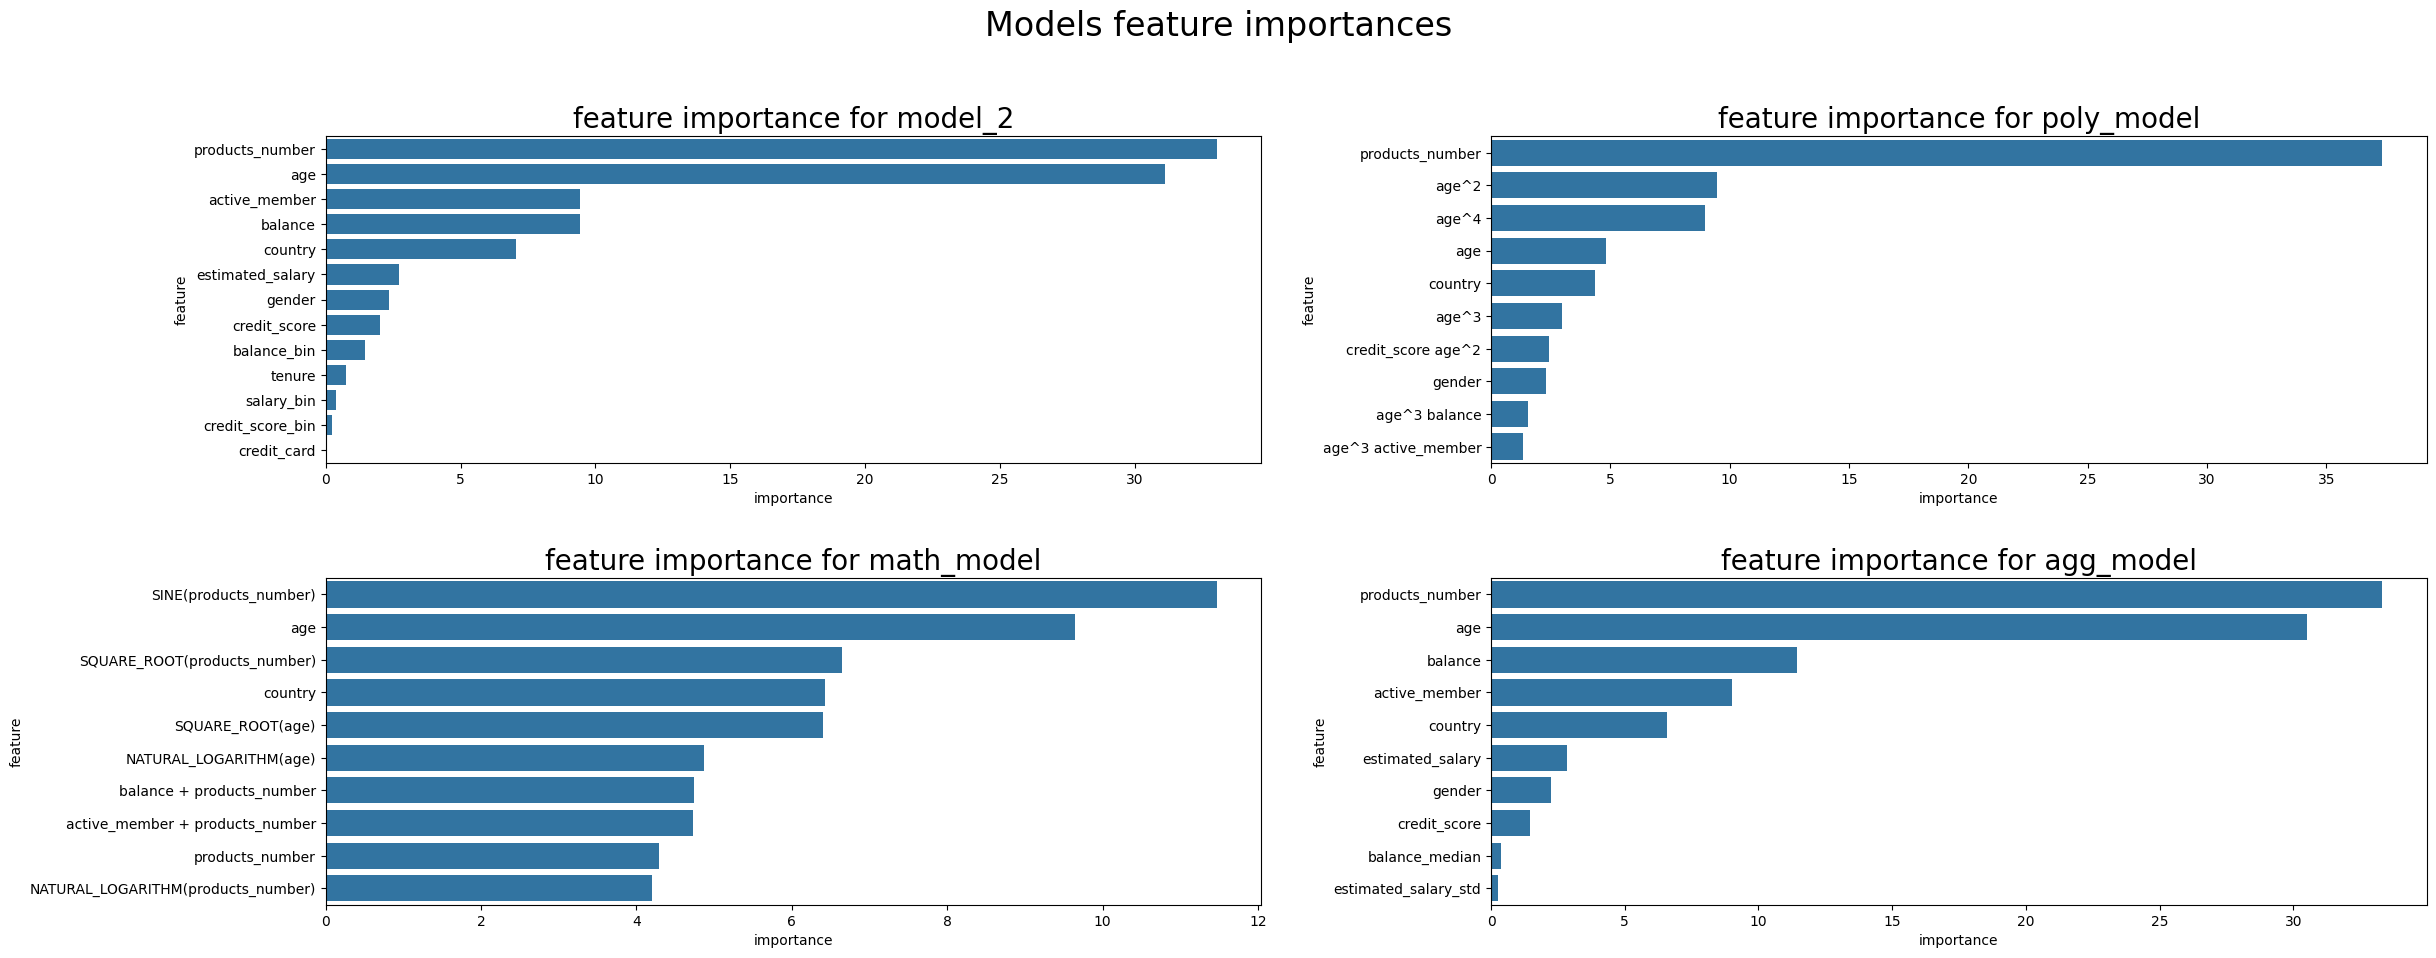

In [41]:
fig, axes = plt.subplots(2,2, figsize=(25, 10))

sns.barplot(ax=axes[0,0], data=feature_importance_2, x='importance', y='feature').set_title('feature importance for model_2', fontsize=20)
sns.barplot(ax=axes[0,1], data=poly_feature_importance.head(10), x='importance', y='feature').set_title('feature importance for poly_model', fontsize=20)
sns.barplot(ax=axes[1,0], data=math_feature_importance.head(10), x='importance', y='feature').set_title('feature importance for math_model', fontsize=20)
sns.barplot(ax=axes[1,1], data=agg_feature_importance.head(10), x='importance', y='feature').set_title('feature importance for agg_model', fontsize=20)

fig.suptitle('Models feature importances', fontsize=24)
fig.tight_layout(pad=3)
plt.show();

> Судя по feature_importance, так или иначе самыми значимыми признаками являются `products_number` и `age`.

#### Создадим модель на основе объединения всех признаков и визуализируем feature importance этой модели

In [42]:
df.shape

(10000, 11)

In [43]:
base_cols=df.columns.to_list()

composite_df=df.merge(
    right=poly_df,
    how='left',
    on=base_cols
).merge(
    right=math_df,
    how='left',
    on=base_cols
).merge(
    right=agg_df,
    how='left',
    on=base_cols
)

In [44]:
comp_model, X_train_comp, y_train_comp, X_test_comp, y_test_comp, model_metrics_comp = fn.build_model(composite_df, cat_features, 'classifier')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

auc_train: 0.7144, auc_test: 0.7072


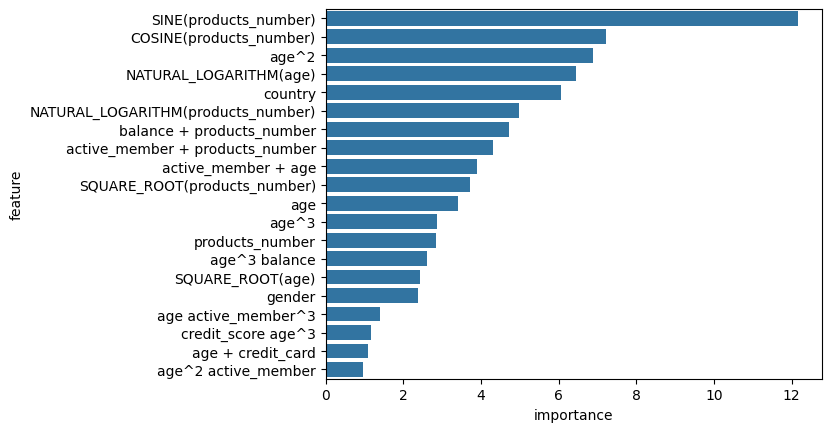

In [45]:
comp_feature_importance=fn.get_feature_importance(comp_model, X_train_comp.columns)
fn.plot_feature_importance(comp_feature_importance.head(20));

#### Создадим модель на основе объединения топ-5 признаков каждого датафрейма и визуализируем feature importance этой модели

In [46]:
base_5_cols=['products_number', 'age', 'active_member', 'balance', 'country', 'age^2', 'age^4', 'SINE(products_number)', 'SQUARE_ROOT(products_number)', 'SQUARE_ROOT(age)']+['churn']

top_5_df=composite_df[base_5_cols]

In [47]:
top_5_model, X_train_top_5, y_train_top_5, X_test_top_5, y_test_top_5, model_metrics_top_5 = fn.build_model(top_5_df, [x for x in cat_features if x in base_5_cols], 'classifier')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

auc_train: 0.7349, auc_test: 0.7324


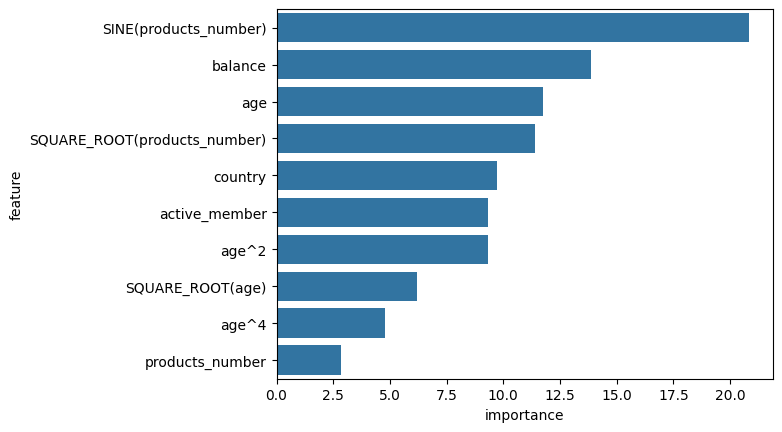

In [48]:
top_5_feature_importance=fn.get_feature_importance(top_5_model, X_train_top_5.columns)
fn.plot_feature_importance(top_5_feature_importance);

### SHAP

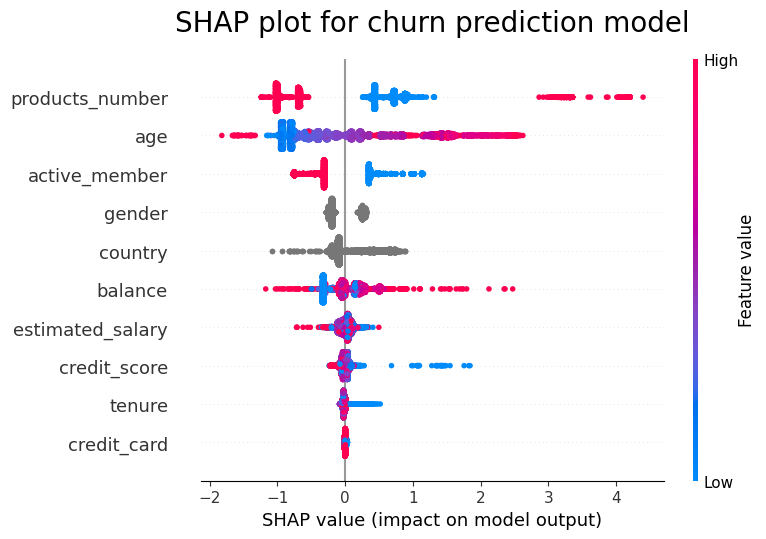

In [49]:
fn.plot_shap(model, 'churn prediction model', X_train)

> Судя по SHAP, самыми значимыми предикторами являются `products_number`, `age`, и `active_member`. 

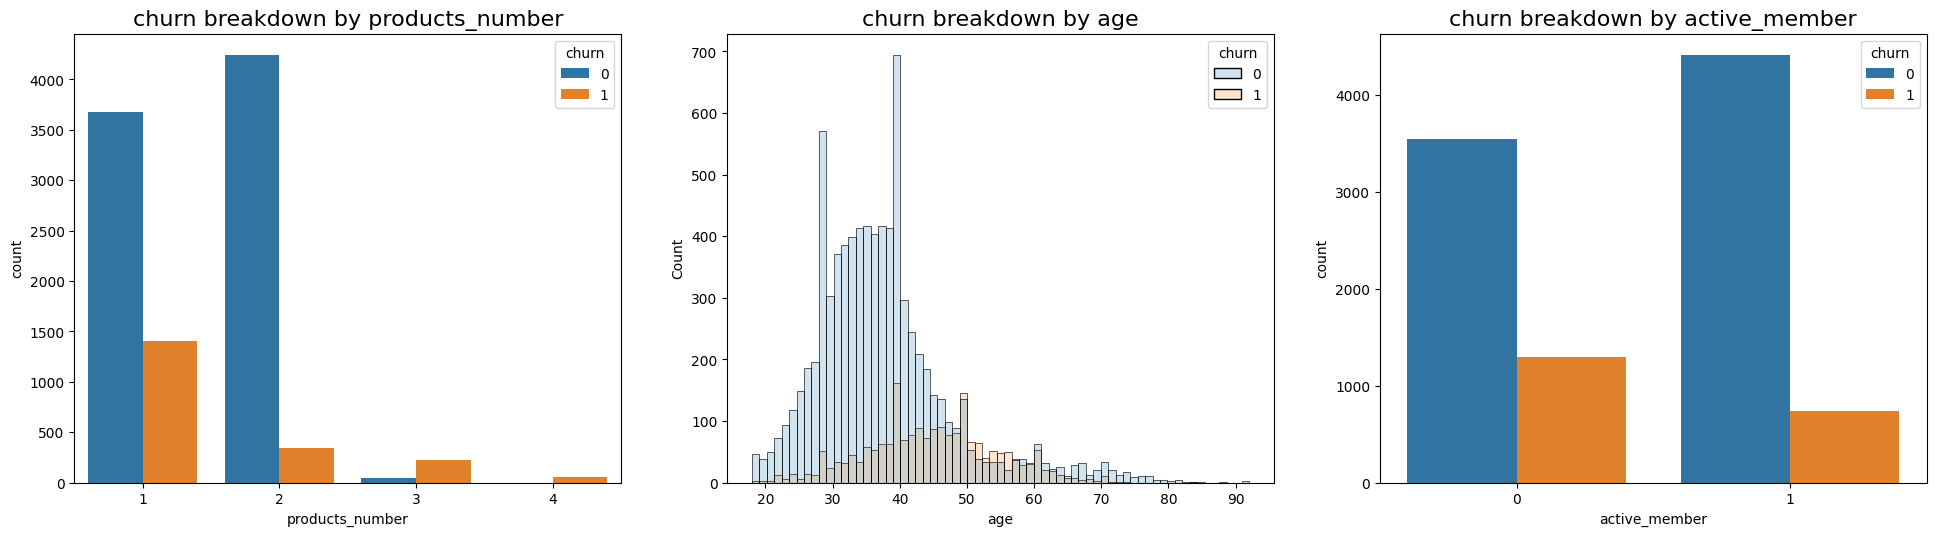

In [50]:
fig, axes = plt.subplots(1,3, figsize=(20, 6))

sns.countplot(data=df, x='products_number', hue='churn', ax=axes[0]).set_title('churn breakdown by products_number', fontsize=16)
sns.histplot(data=df, x='age', hue='churn', alpha=.2, ax=axes[1]).set_title('churn breakdown by age', fontsize=16)
sns.countplot(data=df, x='active_member', hue='churn', ax=axes[2]).set_title('churn breakdown by active_member', fontsize=16)

# sns.countplot(data=df, x='gender', hue='churn', ax=axes[0]).set_title('churn breakdown by gender', fontsize=20)
# sns.countplot(data=df, x='country', hue='churn', ax=axes[1]).set_title('churn breakdown by country', fontsize=20)

#fig.suptitle('Models feature importances', fontsize=24)
fig.tight_layout(pad=3)
plt.show();



***products_number***

> В разбивке по количеству продуктов:  
        * 1 - значимый процент оттока  
        * 2 - наименьший процент оттока  
        * >2 - наибольший процент оттока  

> Получается, что для банка выигрышной стратегией, с точки зрения уменьшения оттока, является увеличение количества клиентов с 2 продуктами, но не более.

***age***

> В возрастной группе до 50 процент удержания больше процента оттока, но при этом с 35 лет наблюдается рост пропорции оттока.

***active_member***

> у активных абонентов процент оттока сравнительно ниже

### Рекурсивный отбор

In [51]:
selected_features=fn.select_features_recursively(
    X=pd.get_dummies(df, columns=['gender', 'country']).drop('churn', axis=1),
    y=df['churn']
)

In [52]:
selected_features

['age',
 'balance',
 'products_number',
 'active_member',
 'gender_Female',
 'country_Germany']

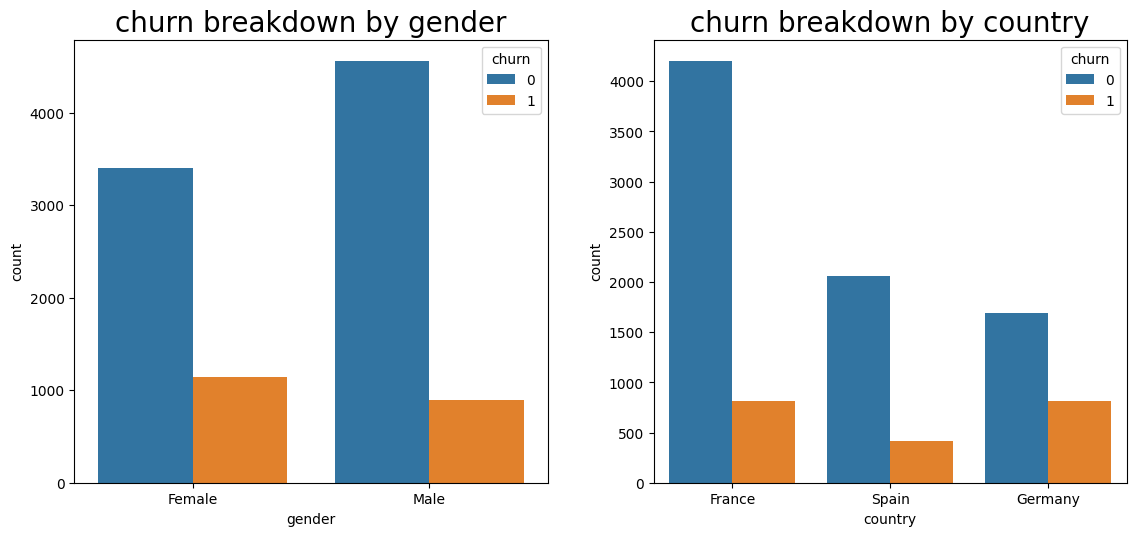

In [53]:
fig, axes = plt.subplots(1,2, figsize=(12, 6))

sns.countplot(data=df, x='gender', hue='churn', ax=axes[0]).set_title('churn breakdown by gender', fontsize=20)
sns.countplot(data=df, x='country', hue='churn', ax=axes[1]).set_title('churn breakdown by country', fontsize=20)

#fig.suptitle('Models feature importances', fontsize=24)
fig.tight_layout(pad=3)
plt.show();

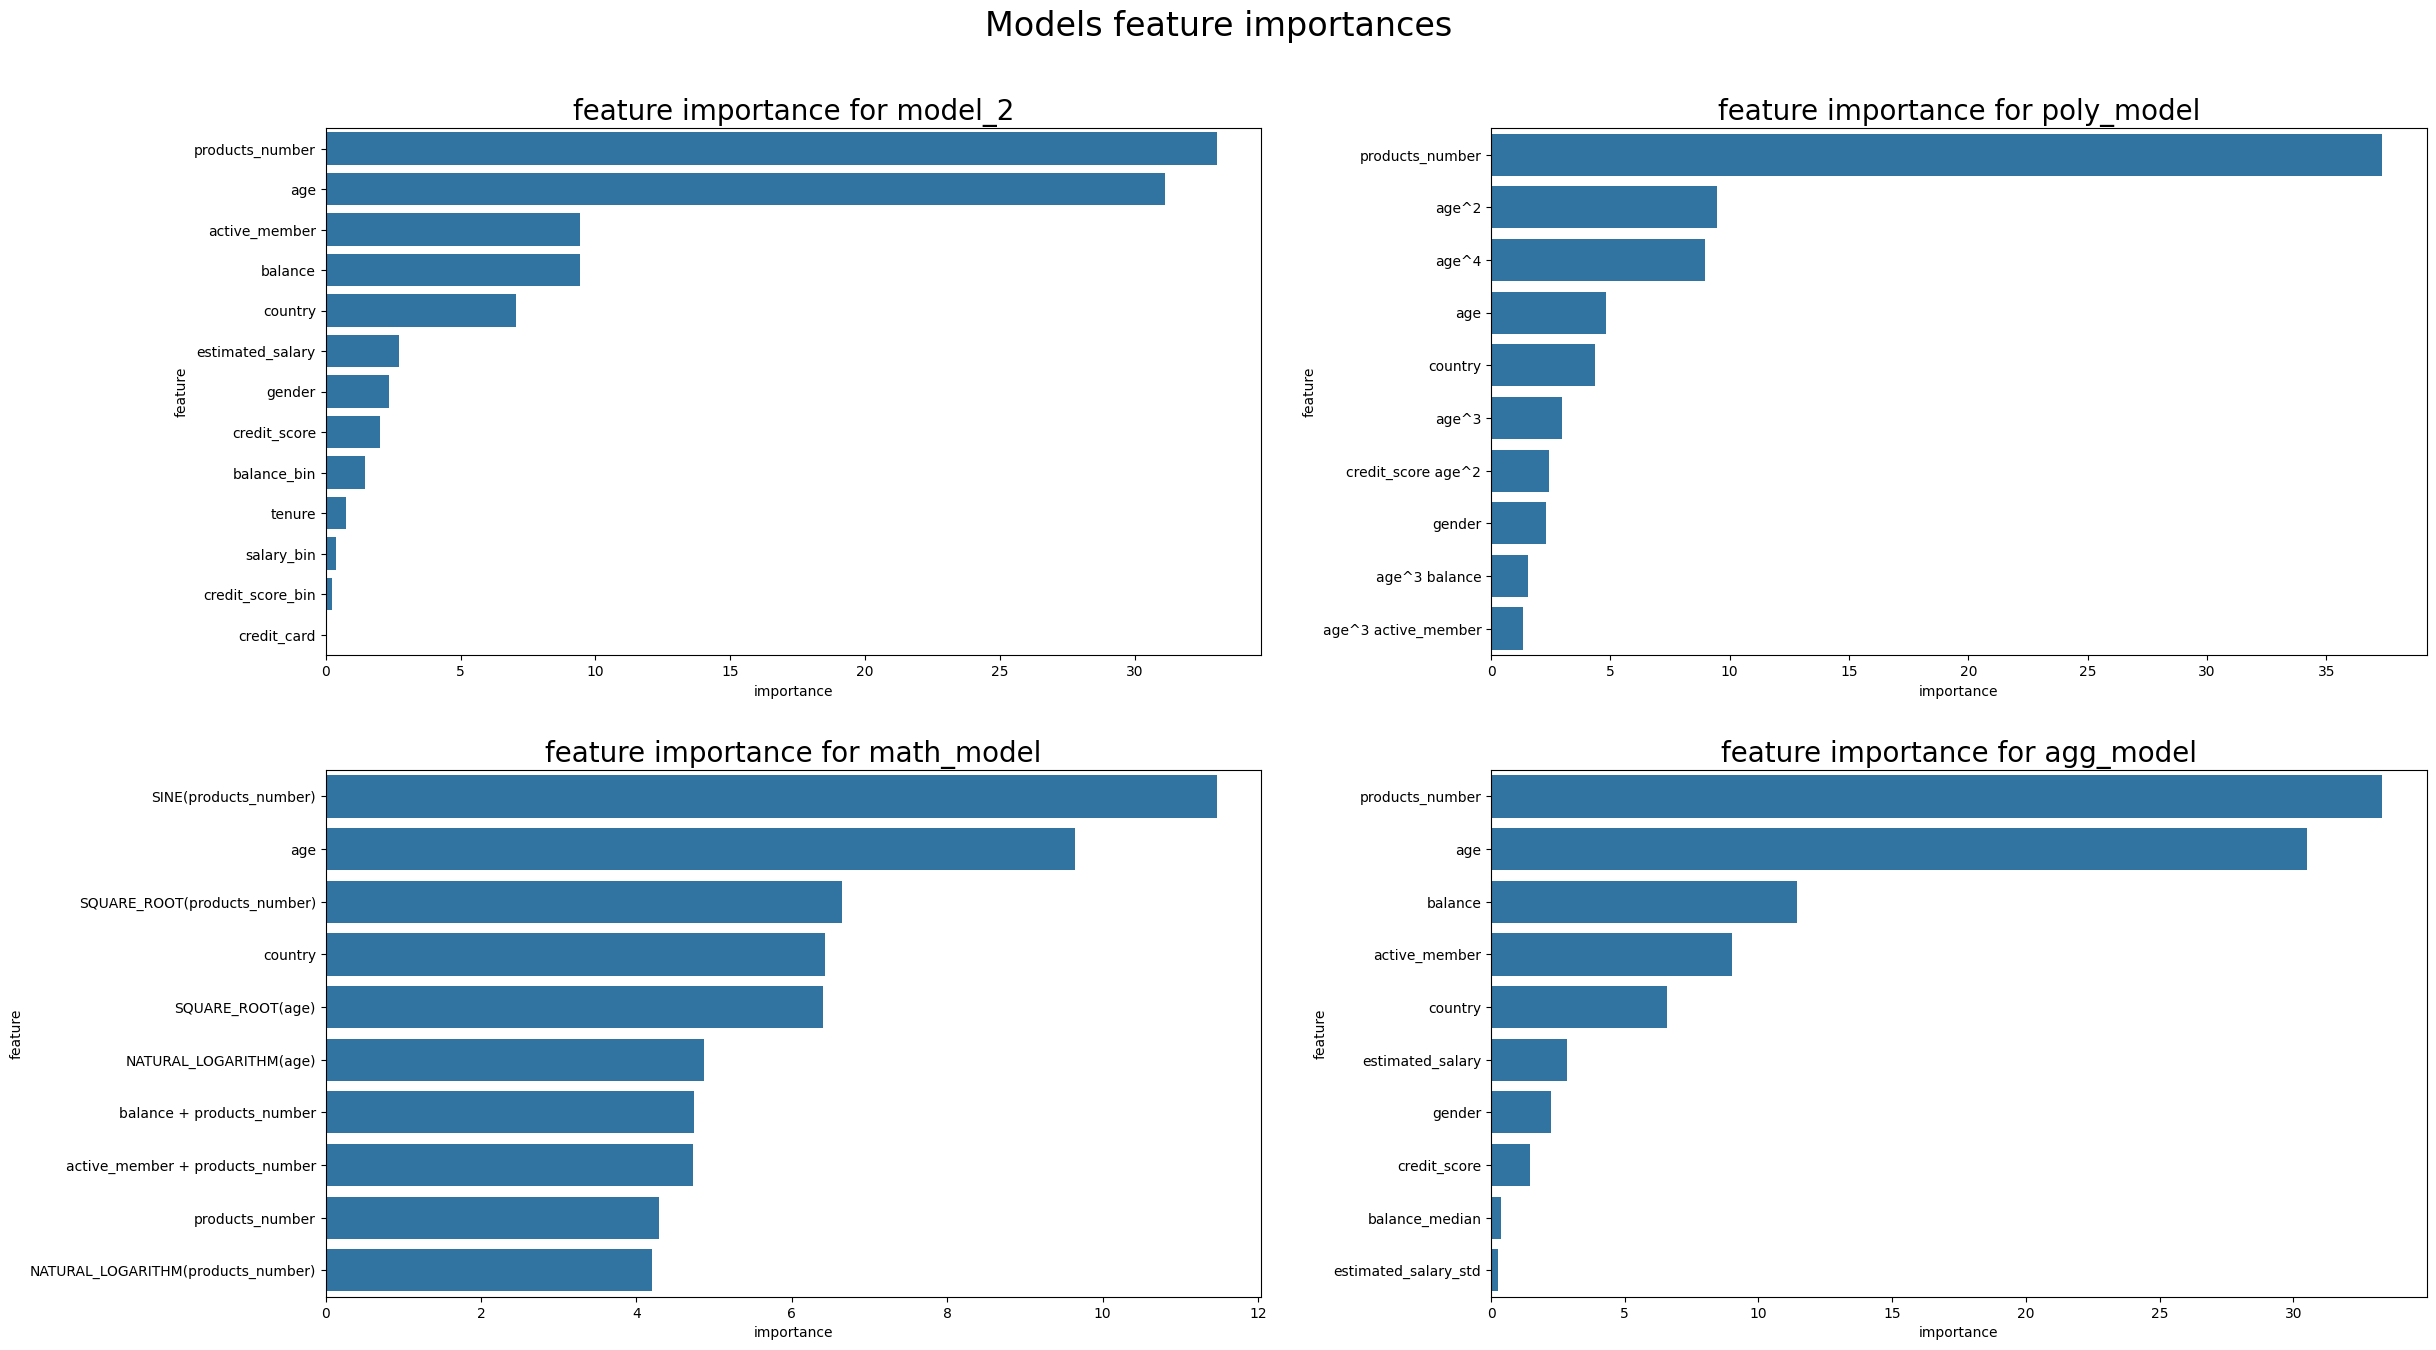

In [54]:
fig, axes = plt.subplots(2,2, figsize=(25, 14))

sns.barplot(ax=axes[0,0], data=feature_importance_2, x='importance', y='feature').set_title('feature importance for model_2', fontsize=20)
sns.barplot(ax=axes[0,1], data=poly_feature_importance.head(10), x='importance', y='feature').set_title('feature importance for poly_model', fontsize=20)
sns.barplot(ax=axes[1,0], data=math_feature_importance.head(10), x='importance', y='feature').set_title('feature importance for math_model', fontsize=20)
sns.barplot(ax=axes[1,1], data=agg_feature_importance.head(10), x='importance', y='feature').set_title('feature importance for agg_model', fontsize=20)

fig.suptitle('Models feature importances', fontsize=24)
fig.tight_layout(pad=3)
plt.show();

In [55]:
rf_df=df[['age', 'balance', 'products_number', 'active_member', 'gender', 'country', 'churn']].assign(
    gender_is_female=lambda d_ : np.where(d_['gender']=='Female', 1, 0),
    country_is_germany=lambda d_: np.where(d_['country']=='Germany', 1, 0)
).copy().drop(labels=['country', 'gender'], axis=1)

In [56]:
rf_model, X_train_rf, y_train_rf, X_test_rf, y_test_rf, model_metrics_rf = fn.build_model(rf_df, ['products_number', 'active_member', 'gender_is_female', 'country_is_germany'], 'classifier')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

auc_train: 0.7323, auc_test: 0.726


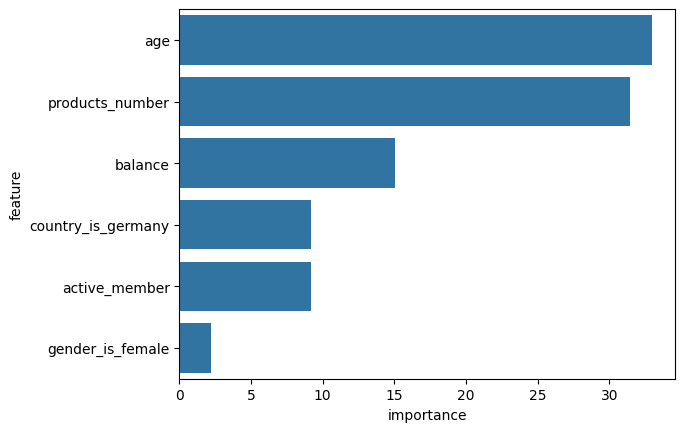

In [57]:
fn.plot_feature_importance(fn.get_feature_importance(rf_model, X_train_rf.columns));

## 5. Стекинг моделей

**Построение StackingClassifier:**
   - Обучите 3 модели классификации на ваш выбор.
   - Постройте **`StackingClassifier`** с метамоделью `CatBoostClassifier`.

In [58]:
log_reg = LogisticRegression(solver='liblinear', max_iter=1000, class_weight='balanced')
rf = RandomForestClassifier(n_estimators=50, n_jobs=-1)
knn = KNeighborsClassifier(n_jobs=-1)
xgb = XGBClassifier(n_jobs=-1)

In [59]:
estimators={
    'log_reg':log_reg,
    'rf':rf,
    'xgb':xgb
    #'knn':knn
}

In [61]:
stacked_model, X_train_st, y_train_st, X_test_st, y_test_st, auc_train, auc_test = fn.build_stacked_model(
    df, 
    ['gender', 'country'],
    estimators
)

LogisticRegression AUC train: 0.6687
LogisticRegression AUC test: 0.6696
RandomForestClassifier AUC train: 0.9982
RandomForestClassifier AUC test: 0.7097
XGBClassifier AUC train: 0.9021
XGBClassifier AUC test: 0.7372

roc_auc_train: 0.9021
roc_auc_test: 0.7372
